In [1]:
!rm -rf sample_data/

## Install libraries

In [2]:
!pip install -U --quiet mlfoundry
!pip install -U --quiet servicefoundry==0.1.69

     |████████████████████████████████| 116 kB 6.3 MB/s 
     |████████████████████████████████| 281 kB 11.6 MB/s 
     |████████████████████████████████| 3.4 MB 15.7 MB/s 
     |████████████████████████████████| 1.2 MB 37.2 MB/s 
     |████████████████████████████████| 132 kB 48.5 MB/s 
     |████████████████████████████████| 181 kB 44.4 MB/s 
     |████████████████████████████████| 2.1 MB 43.4 MB/s 
     |████████████████████████████████| 77 kB 4.5 MB/s 
     |████████████████████████████████| 596 kB 45.6 MB/s 
     |████████████████████████████████| 79 kB 5.4 MB/s 
     |████████████████████████████████| 9.0 MB 43.7 MB/s 
     |████████████████████████████████| 139 kB 12.0 MB/s 
     |████████████████████████████████| 59 kB 5.1 MB/s 
     |████████████████████████████████| 141 kB 42.7 MB/s 
     |████████████████████████████████| 1.6 MB 9.7 MB/s 
     |████████████████████████████████| 63 kB 702 kB/s 
     |████████████████████████████████| 127 kB 43.8 MB/s 
     |██████████████████

## Load datasets

In [24]:
# load our datasets as dataframes
import pandas as pd

movie_meta_df = pd.read_csv('https://raw.githubusercontent.com/srihari-tf/recommender-system-tfy/master/movies_metadata.csv')
keywords_df = pd.read_csv('https://raw.githubusercontent.com/srihari-tf/recommender-system-tfy/master/keywords.csv')
ratings_df = pd.read_csv("https://raw.githubusercontent.com/srihari-tf/recommender-system-tfy/master/ratings_small.csv")

movie_meta_df = movie_meta_df[movie_meta_df['id'].isin(ratings_df['movieId'].astype('string'))]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
!curl -O https://raw.githubusercontent.com/srihari-tf/recommender-system-tfy/master/movies_metadata.csv
!curl -O https://raw.githubusercontent.com/srihari-tf/recommender-system-tfy/master/ratings_small.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32.8M  100 32.8M    0     0   211M      0 --:--:-- --:--:-- --:--:--  211M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2381k  100 2381k    0     0  31.0M      0 --:--:-- --:--:-- --:--:-- 31.0M


## Clean dataset

In [25]:
meta_df = movie_meta_df.copy()
meta_df.drop(['belongs_to_collection', 'homepage', 'tagline', 'poster_path', 'overview', 'imdb_id', 'spoken_languages'], inplace=True, axis=1)
meta_df.dropna(inplace=True)

In [26]:
import ast

column_changes = ['production_companies', 'production_countries', 'genres']
json_shrinker_dict = dict({'production_companies': list(), 'production_countries': list(), 'genres': list()})

for col in column_changes:
    if col == 'production_companies':
        for i in meta_df[col]:
            i = ast.literal_eval(i)
            if len(i) < 1:
                json_shrinker_dict['production_companies'].append(None)

            for element in i:
                json_shrinker_dict['production_companies'].append(element['name'])
                break
    elif col == 'production_countries':
        for i in meta_df[col]:
            i = ast.literal_eval(i)
            if len(i) < 1:
                json_shrinker_dict['production_countries'].append(None)
            for element in i:
                json_shrinker_dict['production_countries'].append(element['iso_3166_1'])
                break
    else:
        for i in meta_df[col]:
            i = ast.literal_eval(i)
            if len(i) < 1:
                json_shrinker_dict['genres'].append(None)

            for element in i:
                json_shrinker_dict['genres'].append(element['name'])
                break

In [27]:
for i in column_changes:
    meta_df[i] = json_shrinker_dict[i]

meta_df.dropna(inplace=True)
meta_df.head()

,adult,budget,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,status,title,video,vote_average,vote_count
5,False,60000000,Action,949,en,Heat,17.924927,Regency Enterprises,US,1995-12-15,187436818.0,170.0,Released,Heat,False,7.7,1886.0
9,False,58000000,Adventure,710,en,GoldenEye,14.686036,United Artists,GB,1995-11-16,352194034.0,130.0,Released,GoldenEye,False,6.6,1194.0
14,False,98000000,Action,1408,en,Cutthroat Island,7.284477,Le Studio Canal+,FR,1995-12-22,10017322.0,119.0,Released,Cutthroat Island,False,5.7,137.0
15,False,52000000,Drama,524,en,Casino,10.137389,Universal Pictures,FR,1995-11-22,116112375.0,178.0,Released,Casino,False,7.8,1343.0
16,False,16500000,Drama,4584,en,Sense and Sensibility,10.673167,Columbia Pictures Corporation,GB,1995-12-13,135000000.0,136.0,Released,Sense and Sensibility,False,7.2,364.0


## Scale features for clustering

In [28]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()
scaled_df = meta_df[['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']]
scaled = scalar.fit_transform(meta_df[['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']])
scaled_df = pd.DataFrame(scaled, index=scaled_df.index, columns=scaled_df.columns)


## Set up MLFoundry to log params and metrics

In [29]:
import mlfoundry

mlfoundry.login()
client = mlfoundry.get_client()
MLF_PROJECT_NAME= "movie-clustering-aug-12"

API key is already configured.
Please use `mlfoundry login --relogin` or `mlfoundry.login(relogin=True)`to force relogin


## Find optimal number of clusters and log to MLFoundry

Link to the dashboard for the run: https://app.truefoundry.com/mlfoundry/256/ed7dc7db99ac41919590fb983954235a/
[mlfoundry] 2022-08-12T14:37:30+0000 WARNING failed to log git info because git repository is not present
[mlfoundry] 2022-08-12T14:37:31+0000 INFO Run 'truefoundry/user-truefoundry/movie-clustering-aug-12/num-clusters-5-24' has started.
[mlfoundry] 2022-08-12T14:37:31+0000 WARNING MlFoundry can't log parmeters with length greater than 250 characters. Discarding centers:[[9.94746329e-03 4.48025893e-02 7.86521333e-03 3.42489782e-01
  7.16730245e-01 2.11050069e-02]
 [1.70407922e-02 3.07943303e-02 6.89119405e-03 3.04113156e-01
  5.72374429e-01 7.63469650e-03]
 [1.46973117e-01 8.89485667e-02 9.51662300e-02 3.87771003e-01
  6.63333333e-01 1.07558853e-01]
 [3.17388248e-01 1.86793710e-01 3.20240546e-01 4.13184932e-01
  7.13972603e-01 3.93235206e-01]
 [4.79338972e-03 1.25583237e-02 4.67289347e-04 2.78013393e-01
  2.57023810e-01 1.38560600e-03]].
[mlfoundry] 2022-08-12T14:37:32+0000 IN

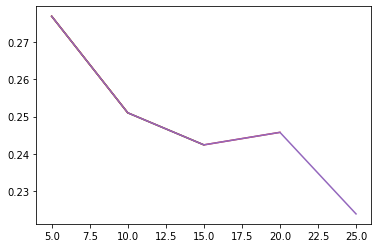

In [73]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

clustering_df = scaled_df[['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']]

cluster_sizes = [5, 10, 15, 20, 25]
scores = []
for index, num_cluster in enumerate(cluster_sizes):
    run = client.create_run(project_name=MLF_PROJECT_NAME, run_name=f"num-clusters-{num_cluster}")
    cluster_fit = KMeans(n_clusters=num_cluster, random_state=0).fit(clustering_df)
    score = silhouette_score(clustering_df, cluster_fit.labels_, metric='euclidean', sample_size=None, random_state=None)
    run.log_params({'num_clusters': num_cluster, 'centers': cluster_fit.cluster_centers_})
    run.log_metrics({'silhouette_score': score})
    scores.append(score)
    plt.plot(cluster_sizes[:index+1], scores)
    run.log_plots({'cluster_vs_score': plt})

## Apply KMeans using optimal number of clusters

In [31]:
def apply_kmeans(df, clusters):
    kmeans = KMeans(n_clusters=clusters, random_state=0)
    cluster_labels = kmeans.fit(df).labels_
    string_labels = ["c{}".format(i) for i in cluster_labels]
    df['cluster_label'] = cluster_labels
    df['cluster_string'] = string_labels

    return df

apply_kmeans(scaled_df, 15)

,budget,popularity,revenue,runtime,vote_average,vote_count,cluster_label,cluster_string
5,0.157895,0.127172,0.101590,0.531250,0.77,0.153721,1,c1
9,0.152632,0.104193,0.190888,0.406250,0.66,0.097318,1,c1
14,0.257895,0.051681,0.005429,0.371875,0.57,0.011166,13,c13
15,0.136842,0.071921,0.062932,0.556250,0.78,0.109463,1,c1
16,0.043421,0.075722,0.073169,0.425000,0.72,0.029668,2,c2
...,...,...,...,...,...,...,...,...
44995,0.052632,0.017912,0.000000,0.750000,0.54,0.000652,14,c14
45318,0.000000,0.000591,0.000000,0.378125,0.65,0.000163,2,c2
45353,0.000000,0.016336,0.000000,0.287500,0.59,0.002690,0,c0
45406,0.000000,0.005701,0.000000,0.284375,0.46,0.000489,9,c9


In [32]:
movie_desc_df = movie_meta_df.copy()
movie_desc_df = movie_desc_df[['overview', 'original_title', 'id']]
movie_desc_df['overview'] = movie_desc_df['overview'].fillna('')

In [77]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [78]:
embeddings_df = pd.DataFrame(embed((movie_desc_df['overview'])).numpy())

In [79]:
embeddings_df.index = movie_desc_df.index

run = client.create_run(project_name=MLF_PROJECT_NAME, run_name=f"embeddings")
cluster_fit = KMeans(n_clusters=15, random_state=0).fit(embeddings_df)
score = silhouette_score(embeddings_df, cluster_fit.labels_, metric='euclidean', sample_size=None, random_state=None)
run.log_metrics({'silhouette_score': score})

Link to the dashboard for the run: https://app.truefoundry.com/mlfoundry/256/7d860cf4e10947bcaa6b2f2df88f29a6/
[mlfoundry] 2022-08-12T14:44:16+0000 WARNING failed to log git info because git repository is not present
[mlfoundry] 2022-08-12T14:44:17+0000 INFO Run 'truefoundry/user-truefoundry/movie-clustering-aug-12/embeddings-31' has started.
[mlfoundry] 2022-08-12T14:44:18+0000 INFO Shutting down background jobs and syncing data for run 'truefoundry/user-truefoundry/movie-clustering-aug-12/embeddings-30', please don't kill this process...
[mlfoundry] 2022-08-12T14:44:19+0000 INFO Finished syncing data for run 'truefoundry/user-truefoundry/movie-clustering-aug-12/embeddings-30'. Thank you for waiting!
Link to the dashboard for the run: https://app.truefoundry.com/mlfoundry/256/f04f9c492ea742c0bed0cdbc44078b3c/
[mlfoundry] 2022-08-12T14:44:21+0000 INFO Metrics logged successfully


## Train a collaborative filtering model using `implicit`

In [36]:
ratings_df['movieId'] = ratings_df['movieId'].astype("category")
ratings_df['userId'] = ratings_df['userId'].astype("category")

In [37]:
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
from scipy.sparse import coo_matrix
import implicit

In [39]:
r = coo_matrix((ratings_df['rating'], (ratings_df['userId'].cat.codes, ratings_df['movieId'].cat.codes)))

In [40]:
import implicit

model = implicit.als.AlternatingLeastSquares(factors=25)
model.fit(r)

/usr/local/lib/python3.7/dist-packages/implicit/utils.py:141: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0030431747436523438 seconds
  ParameterWarning,


  0%|          | 0/15 [00:00<?, ?it/s]

In [41]:
user_category_to_code = dict([(category, code) for code, category in enumerate(ratings_df.userId.cat.categories)])

def get_movie_names_from_movie_category_codes(movie_cat_codes):
  ids = [ratings_df['movieId'].cat.categories[i] for i in movie_cat_codes]
  return list(movie_meta_df.loc[movie_meta_df['id'].isin([str(id) for id in ids])].original_title)

def get_recommendation_for_user(user_id):
  user_cat_code = user_category_to_code[user_id]
  return get_movie_names_from_movie_category_codes(model.recommend(user_cat_code, r.tocsr().getrow(user_cat_code))[0])
  

In [22]:
get_recommendation_for_user(11)

['Sleepless in Seattle',
 'The Talented Mr. Ripley',
 'The Million Dollar Hotel',
 'Mere Brother Ki Dulhan',
 'Confession of a Child of the Century']

## Save the model and log it to MLFoundry

In [23]:
model.save('recommendation-model')

In [34]:
run = client.create_run(project_name=MLF_PROJECT_NAME, run_name=f"cf-model")
run.log_artifact('/content/recommendation-model.npz')
run.log_artifact('/content/ratings_small.csv')
run.log_artifact('/content/movies_metadata.csv')

[mlfoundry] 2022-08-12T05:52:04+0000 INFO project movie-clustering-aug-12 does not exist. Creating movie-clustering-aug-12.
Link to the dashboard for the run: https://app.truefoundry.com/mlfoundry/256/768659a10bd541fbb9c431ae33752f5d/
[mlfoundry] 2022-08-12T05:52:06+0000 WARNING failed to log git info because git repository is not present
[mlfoundry] 2022-08-12T05:52:06+0000 INFO Run 'truefoundry/user-truefoundry/movie-clustering-aug-12/cf-model' has started.
[mlfoundry] 2022-08-12T05:52:06+0000 INFO Logging '/content/recommendation-model.npz' file as artifact to 'recommendation-model.npz', this might take a while ...
[mlfoundry] 2022-08-12T05:52:07+0000 INFO Shutting down background jobs and syncing data for run 'truefoundry/user-truefoundry/movie-clustering-jul-29-1/cf-model-31', please don't kill this process...
[mlfoundry] 2022-08-12T05:52:08+0000 INFO Finished syncing data for run 'truefoundry/user-truefoundry/movie-clustering-jul-29-1/cf-model-31'. Thank you for waiting!
Link to 

In [48]:
client = mlfoundry.get_client(api_key='djE6dHJ1ZWZvdW5kcnk6dXNlci10cnVlZm91bmRyeTo0ZDlkM2M=')
run = client.get_run('truefoundry/user-truefoundry/movie-clustering-aug-12/cf-model')

movies_local_path = run.download_artifact('movies_metadata.csv')
ratings_local_path = run.download_artifact('ratings_small.csv')

movie_meta_df = pd.read_csv(movies_local_path)
ratings_df = pd.read_csv(ratings_local_path)

Link to the dashboard for the run: https://app.truefoundry.com/mlfoundry/256/768659a10bd541fbb9c431ae33752f5d/


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [49]:
# only keep movies in ratings dataset
movie_meta_df = movie_meta_df[movie_meta_df['id'].isin(ratings_df['movieId'].astype('string'))]

ratings_df['movieId'] = ratings_df['movieId'].astype("category")
ratings_df['userId'] = ratings_df['userId'].astype("category")
r = coo_matrix((ratings_df['rating'], (ratings_df['userId'].cat.codes, ratings_df['movieId'].cat.codes)))

user_category_to_code = dict([(category, code) for code, category in enumerate(ratings_df.userId.cat.categories)])
movie_category_to_code = dict([(category, code) for code, category in enumerate(ratings_df.movieId.cat.categories)])

model_local_path = run.download_artifact('recommendation-model.npz')
model = implicit.als.AlternatingLeastSquares(factors=25).load(model_local_path)

def search_movie(name):
  return (movie_meta_df.loc[movie_meta_df['original_title'].str.contains(name, case=False)][['original_title', 'id']]).to_dict('records')

def find_similar_movie(movie_name):
  search_result =search_movie(movie_name)
  if len(search_result) > 0:
    movie_id = search_result[0]['id']
    movie_name = search_result[0]['original_title']
  else:
    return []
  movie_cat_code = movie_category_to_code[int(movie_id)]
  movie_cat_codes = model.similar_items(movie_cat_code)[0]
  ids = [ratings_df['movieId'].cat.categories[i] for i in movie_cat_codes]
  return movie_name, list(movie_meta_df.loc[movie_meta_df['id'].isin([str(id) for id in ids])].original_title)
 
def get_movie_names_from_movie_category_codes(movie_cat_codes):
  ids = [ratings_df['movieId'].cat.categories[i] for i in movie_cat_codes]
  return list(movie_meta_df.loc[movie_meta_df['id'].isin([str(id) for id in ids])].original_title)

def get_recommendation_for_user(user_id):
  user_cat_code = user_category_to_code[int(user_id)]
  movie_cat_codes = model.recommend(user_cat_code, r.tocsr().getrow(user_cat_code))[0]
  ids = [ratings_df['movieId'].cat.categories[i] for i in movie_cat_codes]
  return list(movie_meta_df.loc[movie_meta_df['id'].isin([str(id) for id in ids])].original_title)

In [60]:
def get_recommendation_for_user_given_movie(user_id, movie_name):
  search_result =search_movie(movie_name)
  if len(search_result) > 0:
    movie_id = search_result[0]['id']
    movie_name = search_result[0]['original_title']
  else:
    return []
  movie_cat_code = movie_category_to_code[int(movie_id)]
  print(movie_cat_code)
  user_cat_code = user_category_to_code[int(user_id)]
  movie_cat_codes = model.rank_items(user_cat_code, r.tocsr().getrow(user_cat_code), model.similar_items(movie_cat_code)[0])[0]
  ids = [ratings_df['movieId'].cat.categories[i] for i in movie_cat_codes]
  return list(movie_meta_df.loc[movie_meta_df['id'].isin([str(id) for id in ids])].original_title)

In [62]:
get_recommendation_for_user_given_movie(10, 'Shawshank Redemption')

250


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: rank_items is deprecated. Use recommend with the 'items' parameter instead
  # This is added back by InteractiveShellApp.init_path()


['The Net',
 'The Shawshank Redemption',
 'Jenseits der Stille',
 'House of Frankenstein',
 '봄 여름 가을 겨울 그리고 봄',
 'Ronja Rövardotter']

## Deploy the app using ServiceFoundry

In [80]:
import servicefoundry.core as sfy
sfy.login()

[mlfoundry] 2022-08-12T19:03:07+0000 INFO Shutting down background jobs and syncing data for run 'truefoundry/user-truefoundry/movie-clustering-aug-12/num-clusters-25-21', please don't kill this process...
[mlfoundry] 2022-08-12T19:03:08+0000 INFO Finished syncing data for run 'truefoundry/user-truefoundry/movie-clustering-aug-12/num-clusters-25-21'. Thank you for waiting!
Link to the dashboard for the run: https://app.truefoundry.com/mlfoundry/256/b38be7e9ffff4077aa19a9395636eeb3/
Login Code: 39L4YL
Waiting for authentication. Go to the following url to complete the authentication: https://app.truefoundry.com/authorize/device?userCode=39L4YL
[green bold]Login Successful![/]
Session file stored at /root/.truefoundry
[yellow]You are logged in as 'user-truefoundry' with email 'user@truefoundry.com'[/]


In [84]:
%%writefile predict.py
import mlfoundry
import pandas as pd
from scipy.sparse import coo_matrix
import implicit

client = mlfoundry.get_client(api_key='djE6dHJ1ZWZvdW5kcnk6dXNlci10cnVlZm91bmRyeTo0ZDlkM2M=')
run = client.get_run('truefoundry/user-truefoundry/movie-clustering-aug-12/cf-model')

movies_local_path = run.download_artifact('movies_metadata.csv')
ratings_local_path = run.download_artifact('ratings_small.csv')

movie_meta_df = pd.read_csv(movies_local_path)
ratings_df = pd.read_csv(ratings_local_path)

# only keep movies in ratings dataset
movie_meta_df = movie_meta_df[movie_meta_df['id'].isin(ratings_df['movieId'].astype('string'))]

ratings_df['movieId'] = ratings_df['movieId'].astype("category")
ratings_df['userId'] = ratings_df['userId'].astype("category")
r = coo_matrix((ratings_df['rating'], (ratings_df['userId'].cat.codes, ratings_df['movieId'].cat.codes)))

user_category_to_code = dict([(category, code) for code, category in enumerate(ratings_df.userId.cat.categories)])
movie_category_to_code = dict([(category, code) for code, category in enumerate(ratings_df.movieId.cat.categories)])

model_local_path = run.download_artifact('recommendation-model.npz')
model = implicit.als.AlternatingLeastSquares(factors=25).load(model_local_path)

def search_movie(name):
  return (movie_meta_df.loc[movie_meta_df['original_title'].str.contains(name, case=False)][['original_title', 'id']]).to_dict('records')

def find_similar_movie(movie_name):
  search_result =search_movie(movie_name)
  if len(search_result) > 0:
    movie_id = search_result[0]['id']
    movie_name = search_result[0]['original_title']
  else:
    return []
  movie_cat_code = movie_category_to_code[int(movie_id)]
  movie_cat_codes = model.similar_items(movie_cat_code)[0]
  ids = [ratings_df['movieId'].cat.categories[i] for i in movie_cat_codes]
  return movie_name, list(movie_meta_df.loc[movie_meta_df['id'].isin([str(id) for id in ids])].original_title)
 
def get_movie_names_from_movie_category_codes(movie_cat_codes):
  ids = [ratings_df['movieId'].cat.categories[i] for i in movie_cat_codes]
  return list(movie_meta_df.loc[movie_meta_df['id'].isin([str(id) for id in ids])].original_title)

def get_recommendation_for_user(user_id):
  user_cat_code = user_category_to_code[int(user_id)]
  movie_cat_codes = model.recommend(user_cat_code, r.tocsr().getrow(user_cat_code))[0]
  ids = [ratings_df['movieId'].cat.categories[i] for i in movie_cat_codes]
  return list(movie_meta_df.loc[movie_meta_df['id'].isin([str(id) for id in ids])].original_title)

def get_similar_movies_for_user(user_id, movie_name):
  search_result =search_movie(movie_name)
  if len(search_result) > 0:
    movie_id = search_result[0]['id']
    movie_name = search_result[0]['original_title']
  else:
    return []
  movie_cat_code = movie_category_to_code[int(movie_id)]
  user_cat_code = user_category_to_code[int(user_id)]
  movie_cat_codes = model.rank_items(user_cat_code, r.tocsr().getrow(user_cat_code), model.similar_items(movie_cat_code)[0])[0]
  ids = [ratings_df['movieId'].cat.categories[i] for i in movie_cat_codes]
  return list(movie_meta_df.loc[movie_meta_df['id'].isin([str(id) for id in ids])].original_title)

Overwriting predict.py


In [85]:
reqs = sfy.gather_requirements("predict.py")

In [86]:
auto_service = sfy.Service("predict.py", reqs, sfy.Parameters(
    name="auto-service",
    workspace="v1:local:my-ws"
))
auto_service.deploy()

Creating directory /content/.servicefoundry/auto-service
Created definition file /content/.servicefoundry/auto-service/servicefoundry.yaml
Created file /content/.servicefoundry/auto-service/main.py
Created file /content/.servicefoundry/auto-service/requirements.txt
Created file /content/.servicefoundry/auto-service/Procfile
Ignoring .servicefoundry


# APIs generated
![](https://github.com/srihari-tf/recommender-system-tfy/raw/master/assets/apis.png)

# Fetching similar movies
![](https://github.com/srihari-tf/recommender-system-tfy/raw/master/assets/get_reco.png)